In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
if not os.getcwd().endswith('CIoTS'):
    os.chdir('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CIoTS import *

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Helper: check if data exists

In [3]:
import os.path

def check_setups(setups, data_path):
    return not missing_setups(setups, data_path)

def missing_setups(setups, data_path):
    missing = []
    for dim, in_edges, tau, autocorr, _, run in setups:
        if not os.path.isfile(data_path + f't={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle'):
            missing.append((dim, in_edges, tau, autocorr, run))
    return missing

# Execution

In [4]:
from itertools import product

dimensions = [3]
incoming_edges = [2, 3, 4]
taus = [5, 10, 15, 20]
autocorrs = [0, 0.75]
data_length = [10000]
runs = range(10)

setups = list(product(dimensions, incoming_edges, taus, autocorrs, data_length, runs))

## 2.1 Simulated: estimate $\hat{\tau}$ for unknown $\tau$

In [6]:
def simulate_stopping(df, stopping, params, col):
    sorted_df = df.sort_values(by='tau estimate')
    idx = stopping.simulate(sorted_df[col].values, **params)
    return sorted_df['tau estimate'].iloc[idx]

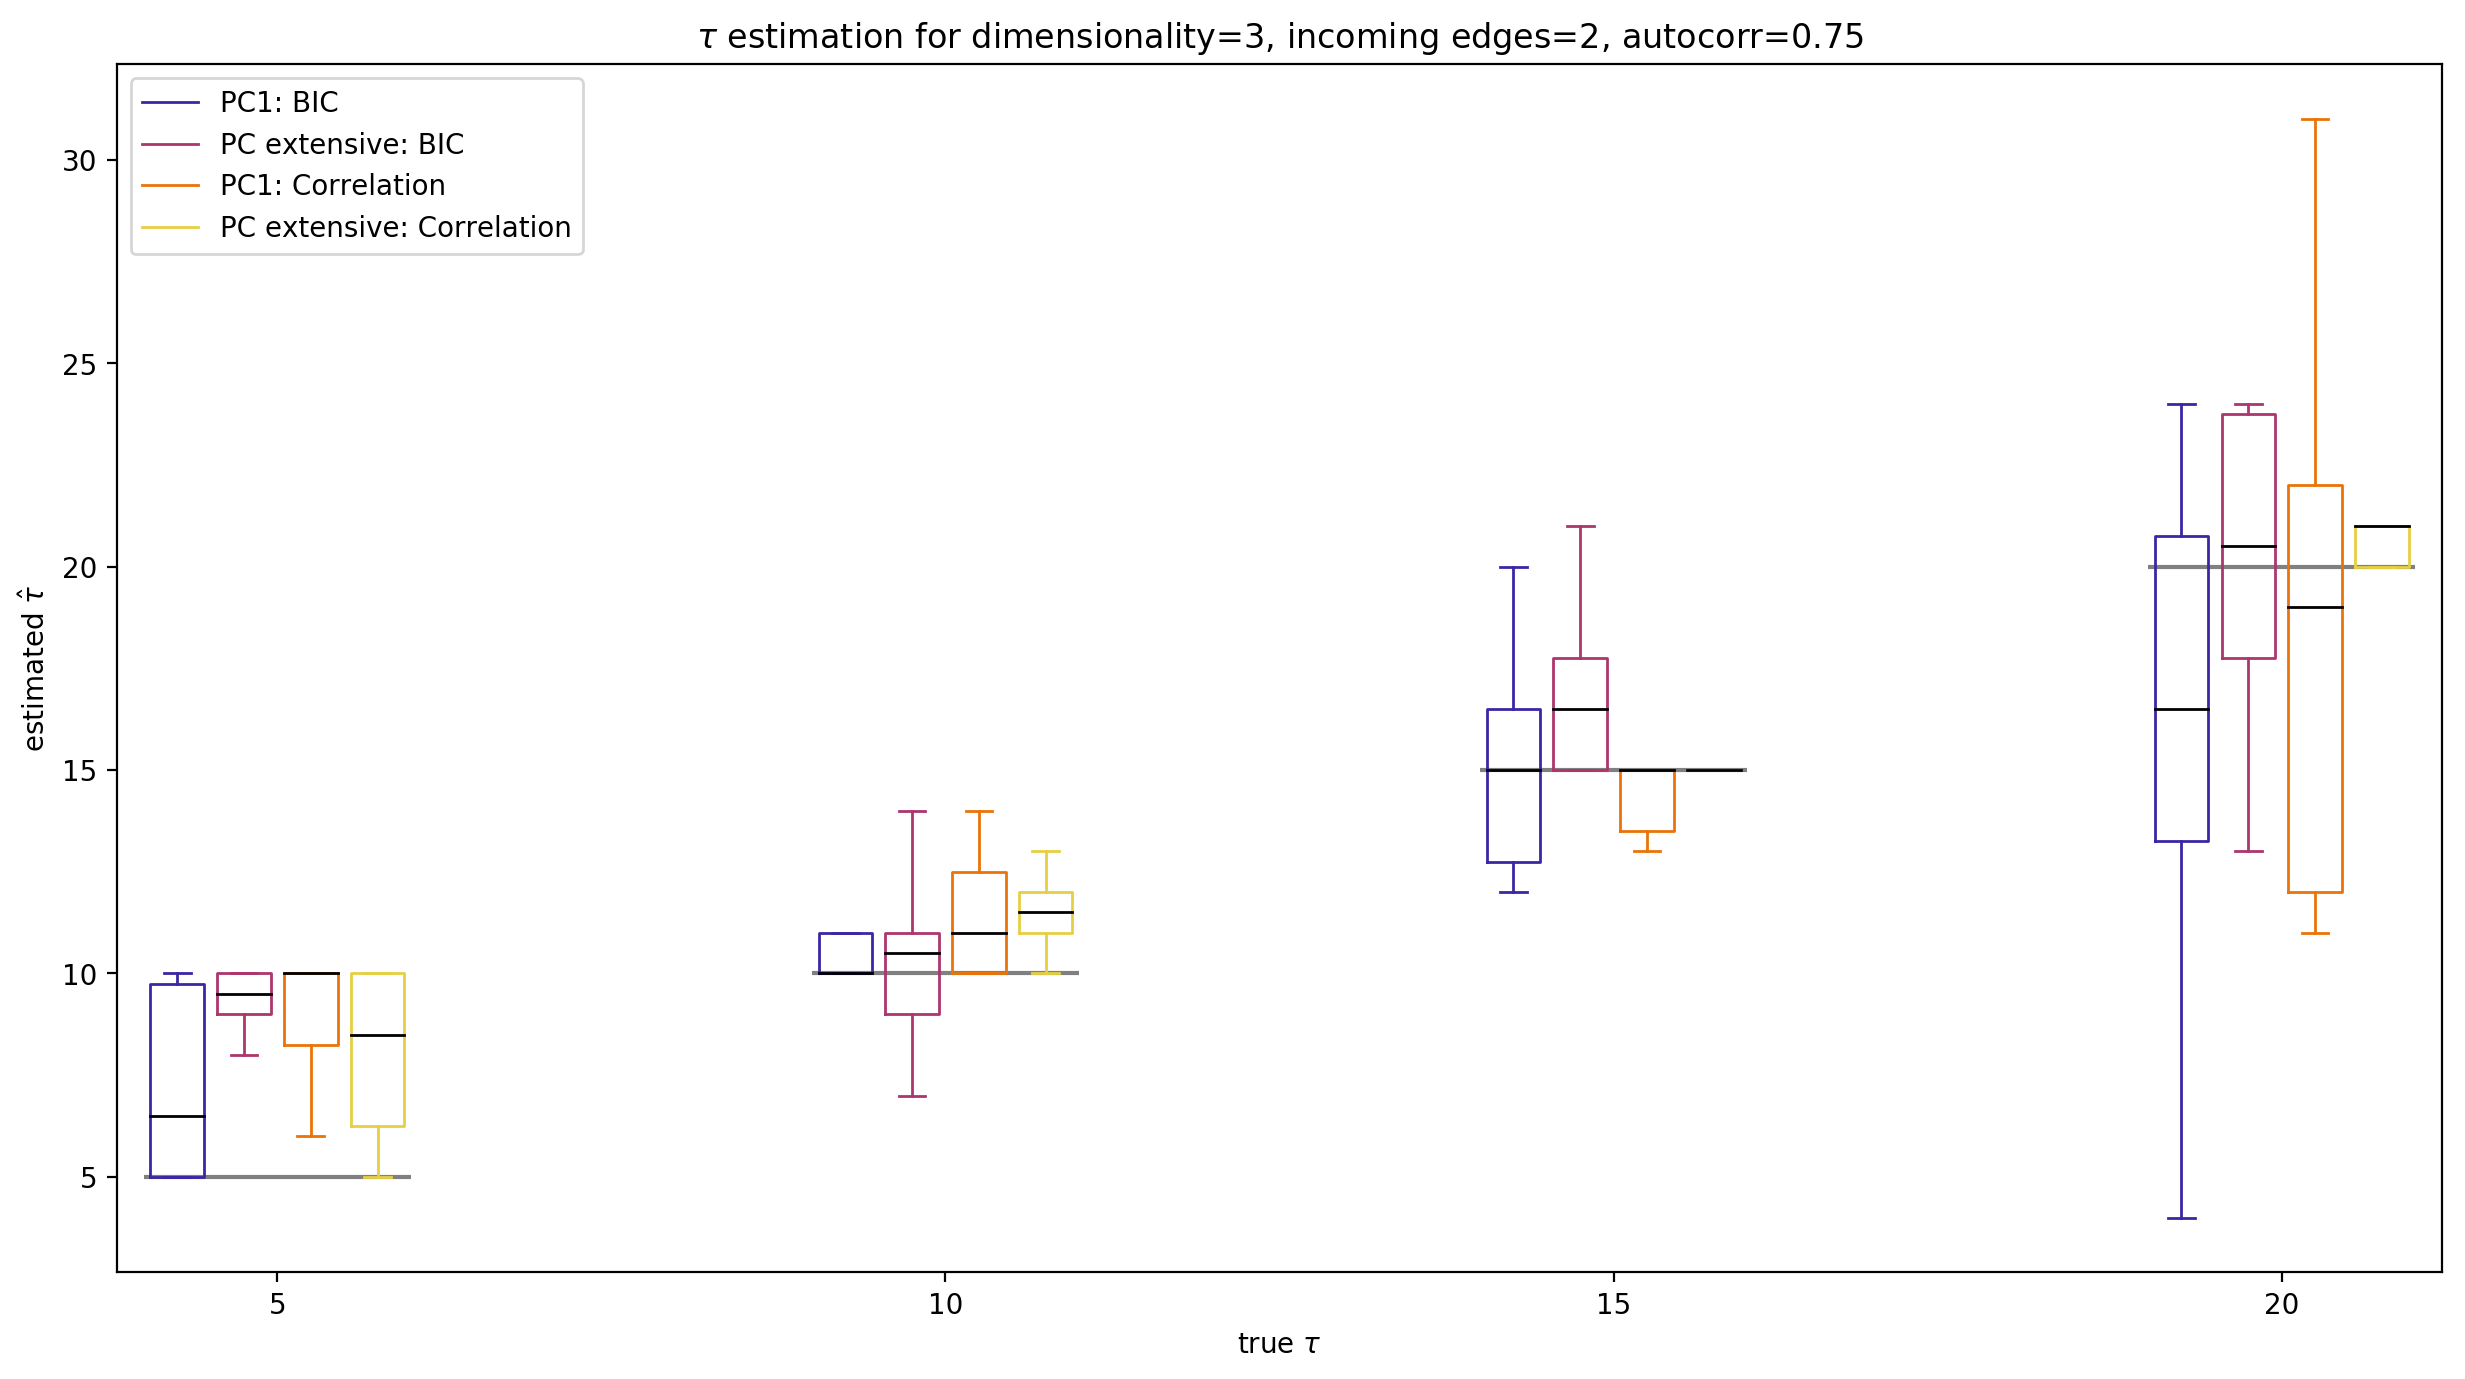

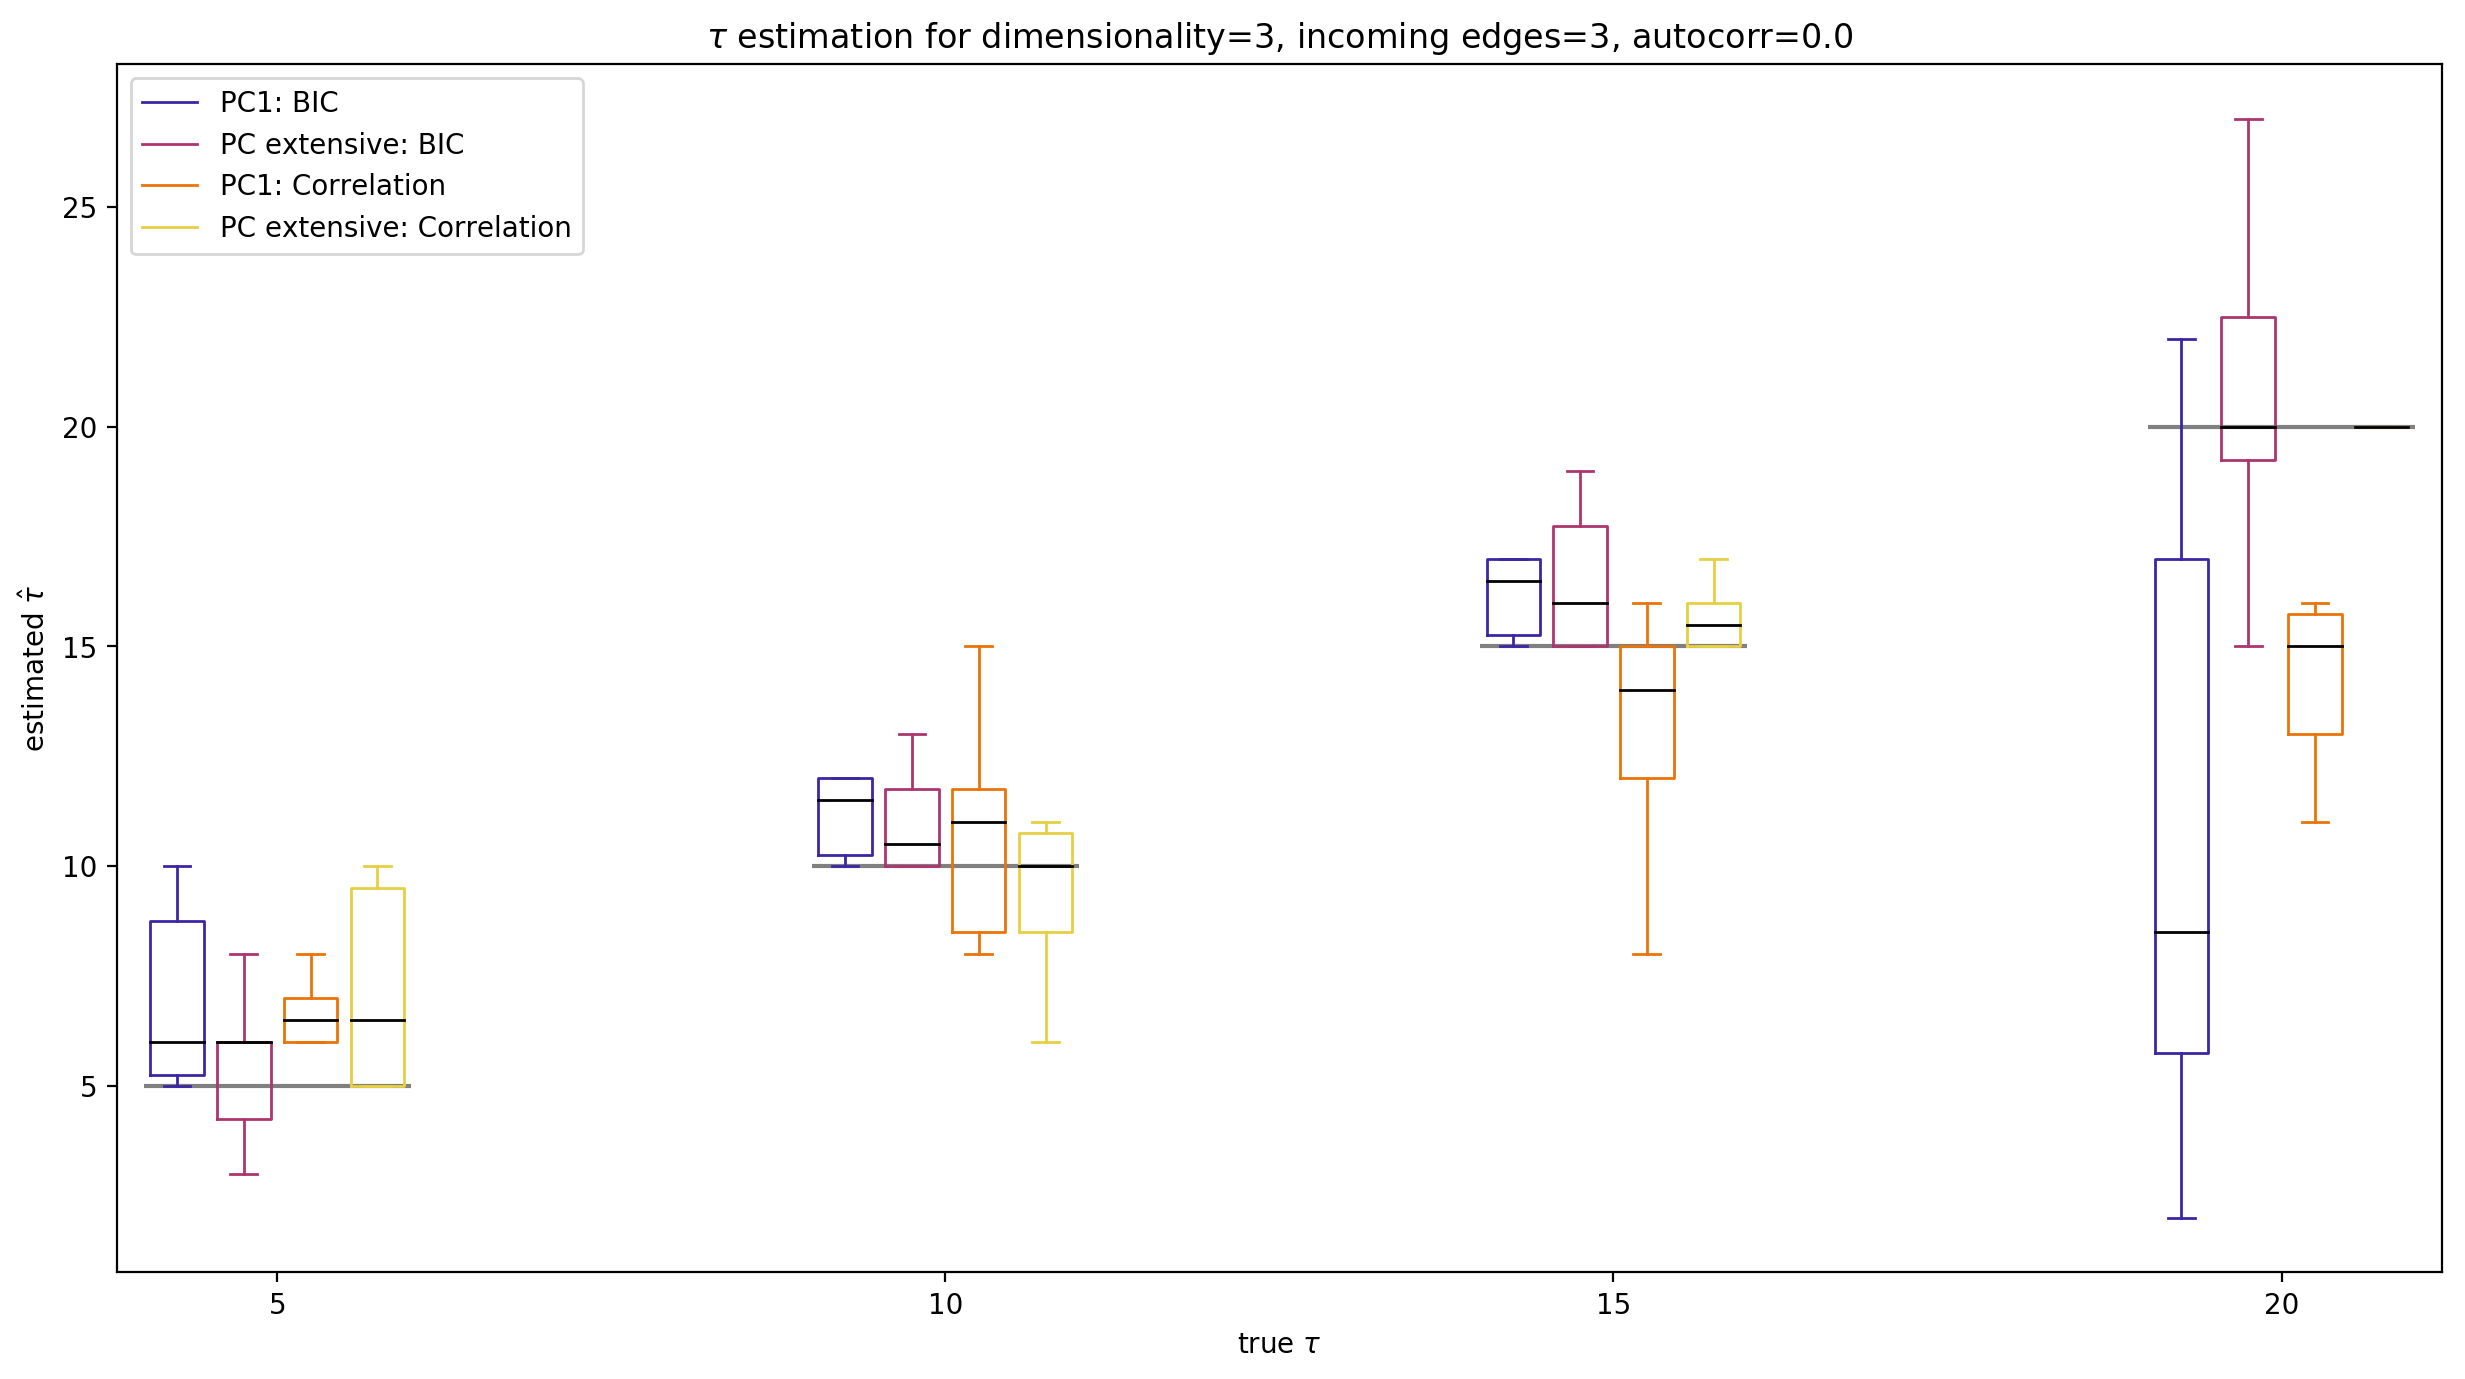

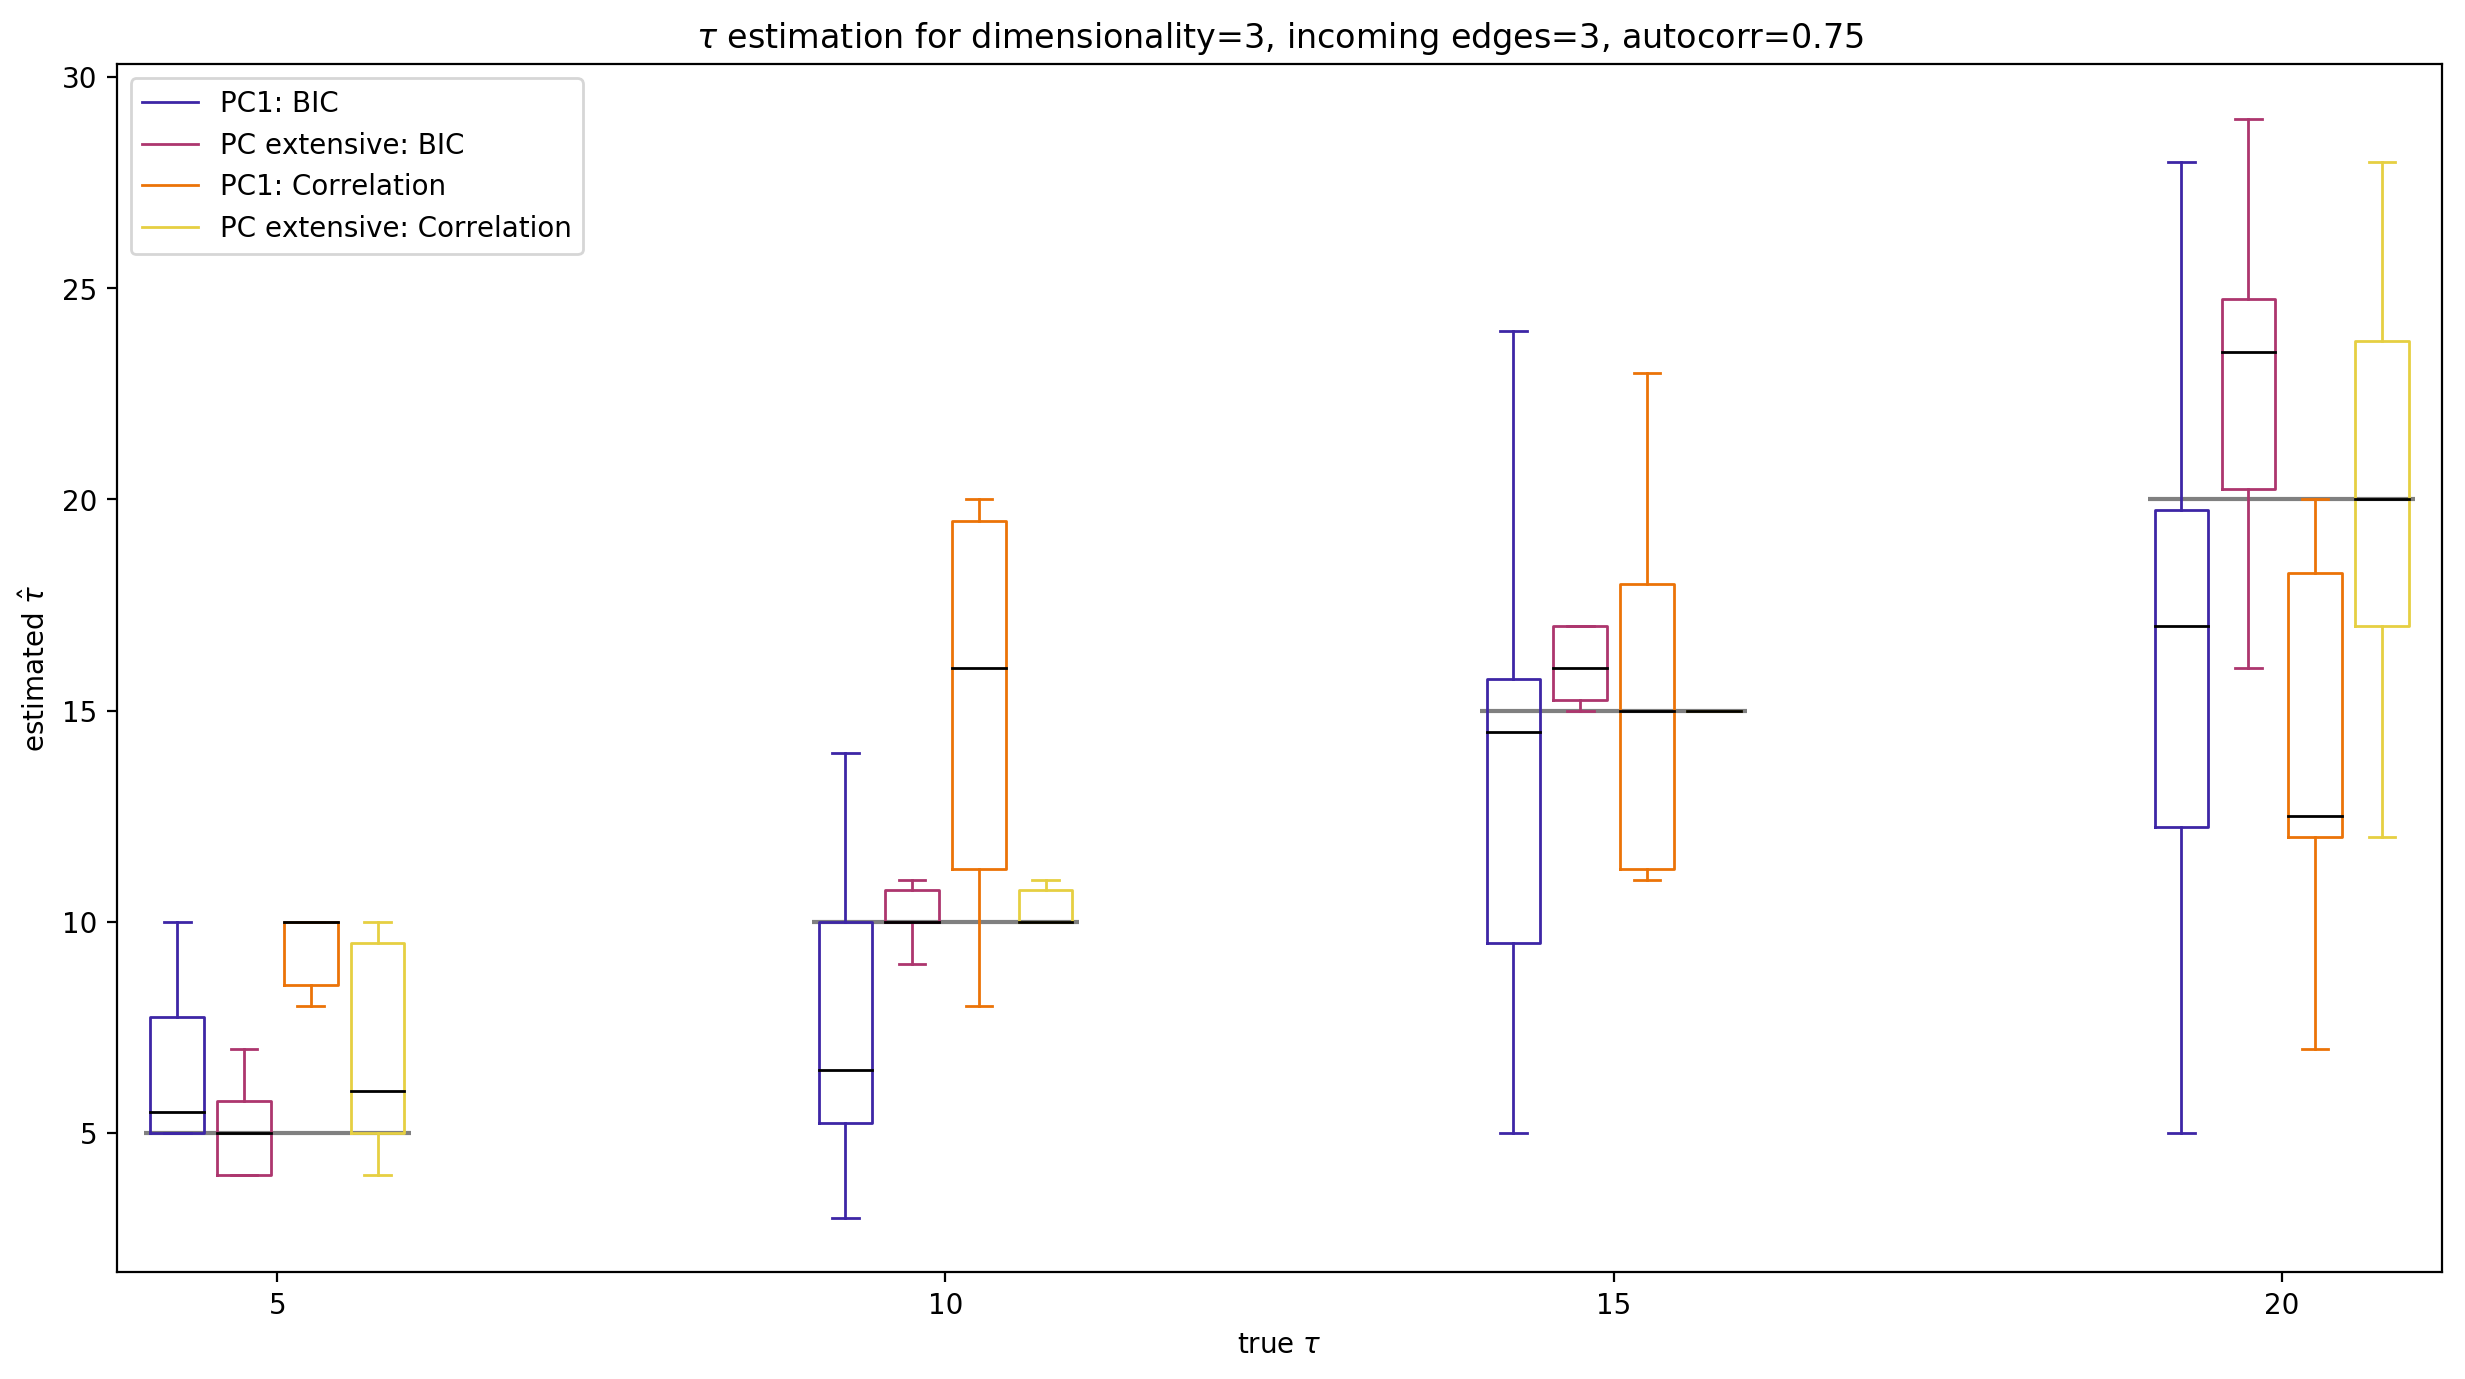

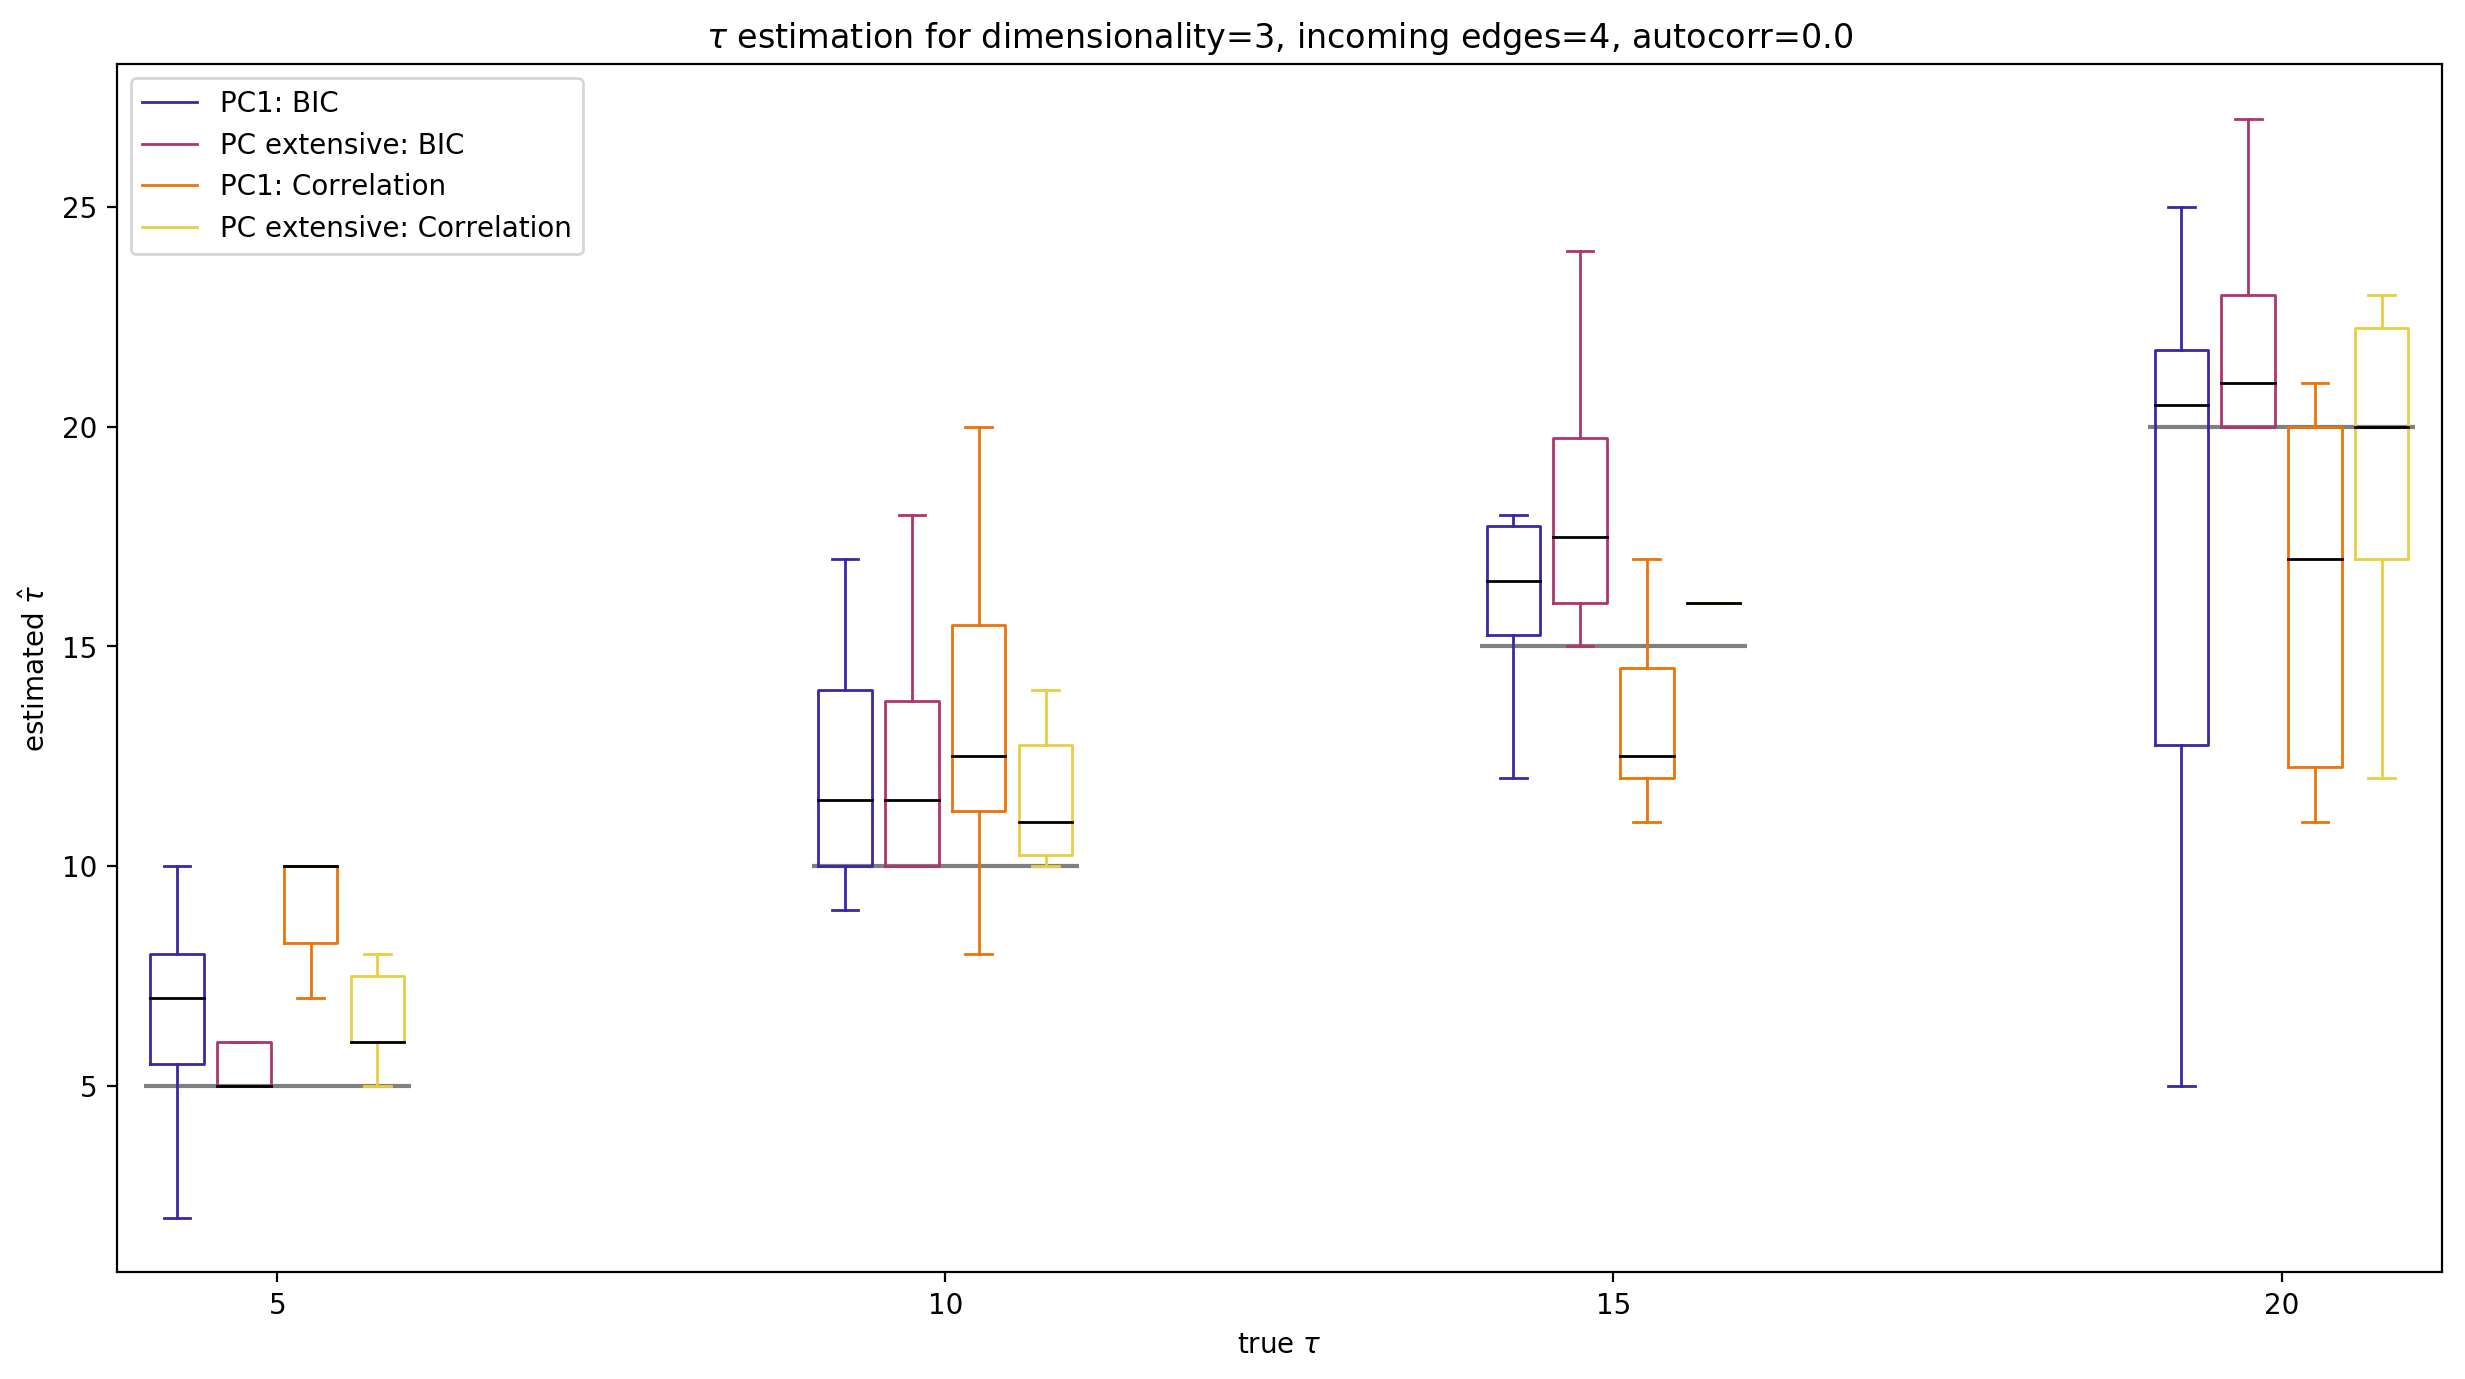

In [13]:
from math import floor

visualize = [(3, 2, 0.75), (3, 3, 0), (3, 3, 0.75), (3, 4, 0)]

# schema: pc_version, stopper_class, params, column_suffix, name
algorithms = [('PC1 incremental', ICStopper, {'patiency': 2}, 'bics', 'PC1: BIC'),
              ('PC extensive', ICStopper, {'patiency': 2}, 'bics', 'PC extensive: BIC'),
              ('PC1 incremental', CorrStopper, {'patiency': 1}, 'added_edges', 'PC1: Correlation'),
              ('PC extensive', CorrStopper, {'patiency': 1}, 'added_edges', 'PC extensive: Correlation')]

width = 0.4
results_path = 'notebooks/ICML/icml_results/'

names = [name for _, _, _, _, name in algorithms]
cols = [name + '_tau' for name in names]

results = pd.read_csv(results_path + 'experiment3.csv')
true_taus = np.unique(results['max time lag'])

for group, result in results.groupby(['dimension', 'incoming edges', 'autocorr']): 
    
    if group not in visualize:
        continue
    
    dim = int(group[0])
    in_edges = int(group[1])
    autocorr = float(group[2])
    
    colors = plt.cm.CMRmap(np.linspace(0,1,len(names)+2))
    plt.figure(dpi=200, figsize=(15, 8))
    
    for tau in true_taus:
        start_x = tau - (width+0.1)*(len(names))/2
        end_x = tau + (width+0.1)*(len(names))/2
        y = tau
        plt.hlines(y, start_x, end_x, colors='grey')
    
    bps = []
    for i, (pc, stopper, params, col_suffix, name) in enumerate(algorithms):
        col = pc + '_' + col_suffix
        positions = [tau + (width+0.1)*(i - (len(names)-1)/2) for tau in true_taus]
        arr = [result[result['max time lag'] == tau].groupby(['run']).apply(lambda df: simulate_stopping(df, 
                                                                                                         stopper, 
                                                                                                         params, 
                                                                                                         col)).values 
               for tau in true_taus]
        bp = plt.boxplot(arr, positions=positions, widths=width, showfliers=False,
                         whiskerprops={'color': colors[i+1]}, boxprops={'color': colors[i+1]},
                         capprops={'color': colors[i+1]}, medianprops={'color': 'black'})
        bps.append(bp)
    
    plt.xlabel('true $\\tau$')
    plt.ylabel('estimated $\\hat{\\tau}$')
    plt.xticks(true_taus, true_taus)
    plt.title(f'$\\tau$ estimation for dimensionality={dim}, incoming edges={in_edges}, autocorr={autocorr}')
    plt.xlim(min(true_taus)-(width+0.2)*len(names)/2, max(true_taus)+(width+0.2)*len(names)/2)
    
    plt.legend([bps[i]['whiskers'][0] for i in range(len(names))], names)
    plt.show()